# IST736 Text Mining - Homework 2
## Martin Alonso 

### Assignment
In this assignment, you will vectorize the data that you collected in HW1. Because the goal is to
identify the public sentiment toward AI on social media, you need to think about what
vectorization options, regarding both what to count and how to count, would be the best for this
goal. Make sure to explain the decisions you made during the vectorization process, e.g., if you
removed stopwords and why.

Write a report to include the following information:  
(1) Briefly recap how you collected the data.  
(2) Describe your vectorization choices and corresponding result. For example, if you chose to do stemming, how did the vocabulary size change after stemming? Did the stemming eliminate important linguistic information that you'd rather keep, or not?  
(3) Conclude with the best vectorization option(s).  
Your report should provide sufficient information for others to replicate what you did. Submit your report with your original data file and the vectors from your best vectorization options.

### Answers
(1) For my previous homework, I used the `twitterscrape` package to collect 200 tweets from Twitter. The library takes as inputs the word (or words) that the user wants to search for, the language, number of tweets to collect, and format of the final file. For my data, I chose to collect the latest 200 tweets that featured either the words "Artificial Intelligence" or "AI". I also made sure that the language was set to English, so as to avoid tweets in French that featured the first person singular conjugation of the verb "etre" (i.e.: "j'ai"). Once the tweets were collected, I exported the file as a comma-separated value file. 
The exported data set featured the following columns: 
* user: Twitter handle
* id: tweet id
* timestamp: date-time tweet was sent
* fullname: user name
* text: tweet  

I replaced the id column, dropped the fullname columns, and added a 'label' column that flagged whether the overall sentiment of the tweet was positive (2), neutral (1), or negative (0). This last column was filled after reading every tweet, which shows my personal bias towards whether I found the tweet to be positive, negative, or neutral. 
Having prepared the data, I loaded it into my workspace and began my sentiment analysis on it. 

(2)

In [10]:
# Import required packages for data upload, preparation, and vectorization
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer
import re 

In [40]:
# Load the data set 
tweets = pd.read_csv('IST736/ai_tweets.csv')
tweets.head()

# Isolate the tweets in a corpus list
corpus = tweets['text']

# Create a count vectorizer that drops any word that contains a number in it, since these words are likely part of the tweet URL and not likely to 
# help in finding most common words.
cv = CountVectorizer(token_pattern=r'\b[^\d\W]+\b')
Xcv = cv.fit_transform(corpus)

# Create a TF-IDF vectorizer to compare results. 
tfidf = TfidfVectorizer(token_pattern=r'\b[^\d\W]+\b')
Xti = tfidf.fit_transform(corpus)

# Print length of the dictionaries to serve as a baseline. 
print("Count Vectorizer words in dictionary: %s" % len(cv.get_feature_names()))
print('TF-IDF Vectorizer words in dictionary: %s' % len(tfidf.get_feature_names()))

Count Vectorizer words in dictionary: 1279
TF-IDF Vectorizer words in dictionary: 1279


In [42]:
# By removing numbers, and words that have numbers within, we've managed to produce two clean dictionaries that features 1,279 words. So far there 
# are no differences between the two vectorizers. 
# Now let's remove both numbers, words with numbers, and English stop words.  

# Second count vectorizer
cv2 = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words='english')
Xcv2 = cv2.fit_transform(corpus)

# Second tf-idf vectorizer
tfidf2 = TfidfVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words='english')
Xti2 = tfidf2.fit_transform(corpus)

# Dictionary length. 
print('Count Vectorizer without stop words: %s' % len(cv2.get_feature_names()))
print('TF-IDF Vectorizer without stop words: %s' % len(tfidf2.get_feature_names()))

# No change whatsoever; both vectorizers have removed the same number of words (143) when removing stop words from the original dictionaries. 

Count Vectorizer without stop words: 1136
TF-IDF Vectorizer without stop words: 1136


In [48]:
# Having removed suspect words and stop words, we'll try stemming as a way to reduce the dictionary. 
# Loads the English-word stemmer from the NLTK package
stemmer = EnglishStemmer()

# Builds Count and TF-IDF analyzers that consider patterns and stop words. 
cv3 = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words='english').build_analyzer()
tfidf3 = TfidfVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words='english').build_analyzer()

# Function that stems every word in the corpus. Loops over every word to find the stemmed word for faster computation
def stemmed_cv_words(doc):
    return (stemmer.stem(w) for w in cv3(doc))

def stemmed_tfidf_words(doc):
    return (stemmer.stem(w) for w in tfidf3(doc))

# Final vectorizer that outputs dictionary lengths
cv_stem = CountVectorizer(analyzer=stemmed_cv_words)
cv3 = cv_stem.fit_transform(corpus)

tfidf_stem = TfidfVectorizer(analyzer=stemmed_tfidf_words)
tfidf3 = tfidf_stem.fit_transform(corpus)

print('Stemmed Count Vectorizer: %s' % len(cv_stem.get_feature_names()))
print('Stemmed TF-IDF Vectorizer: %s' % len(tfidf_stem.get_feature_names()))

# Again, both dictionaries have reduced the same number of words, dropping 108 words for a final tally of 1,028 words in the dictionary. 

Stemmed Count Vectorizer: 1028
Stemmed TF-IDF Vectorizer: 1028


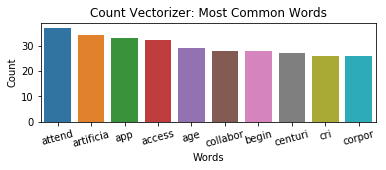

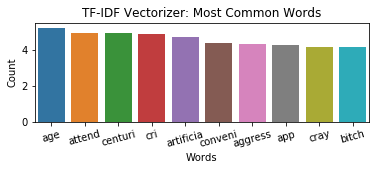

In [136]:
# Hovewer, we should check the most common words in each vectorizer. Perhaps this will give us a clue as to whether the vectorizers are acting similarly.
import seaborn as sns
import matplotlib.pyplot as plt

# Gets the labels and sum of words for Count Vectorizer. Then, we convert to Pandas series and Data Frame to order data by most common words. 
# Finally, we plot the most common words to see how the vectorizer has stemmed the words. 
cv_labels, cv_values = cv_stem.get_feature_names(), cv3.sum(axis=1)
cv_labels = pd.Series(cv_labels)
cv_values = pd.DataFrame(cv_values)
cv_count = pd.concat([cv_labels, cv_values], axis=1, ignore_index=True)
cv_count.columns = ['labels', 'values']
cv_count = cv_count.sort_values(by=['values'], ascending=False)

# Repeat the process for the TF-IDF Vectorizer. 
tfidf_labels, tfidf_values = tfidf_stem.get_feature_names(), tfidf3.sum(axis=1)
tfidf_labels = pd.Series(tfidf_labels)
tfidf_values = pd.DataFrame(tfidf_values)
tfidf_count = pd.concat([tfidf_labels, tfidf_values], axis=1, ignore_index=True)
tfidf_count.columns = ['labels', 'values']
tfidf_count = tfidf_count.sort_values(by=['values'], ascending=False)

# Select the top ten most common words to verify if the vectorizers are splitting the same way. 
cv_count_top10 = cv_count[:10]
tfidf_count_top10 = tfidf_count[:10]

# Plot the vectorizers for visual comparison. 
plt.subplot(2, 1, 1)
sns.barplot(x='labels', y='values', data=cv_count_top10)
_ = plt.xlabel('Words')
_ = plt.xticks(rotation=15)
_ = plt.ylabel('Count')
_ = plt.title('Count Vectorizer: Most Common Words')
plt.show()

plt.subplot(2, 1, 2)
sns.barplot(x='labels', y='values', data=tfidf_count_top10)
_ = plt.xlabel('Words')
_ = plt.xticks(rotation=15)
_ = plt.ylabel('Count')
_ = plt.title('TF-IDF Vectorizer: Most Common Words')
plt.show()

We can see that, despite featuring the same number of words, both vectorizers do not count the frequencies of these the same way. There are some words in common (i.e. 'age', 'artificia', 'app', 'attend', 'centuri' are all featured in both vectorizers top 10) but the term frequency is calculated differently. 


### Conclusions
(3) 